### Try to illustrate the concept of density via dimensionality reduction

In [2]:
import plotnine as pn
import pandas as pd
import numpy as np

from sciterra import Atlas

from sklearn.manifold import TSNE

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Load atlas
fn = "/Users/nathanielimel/uci/projects/citesim/outputs/librarian=S2/vectorizer=SciBERT/center=Imeletal2022"
atl = Atlas.load(fn)

len(atl)

30212

In [3]:
# Get vectors
atl.projection.embeddings.shape

(30212, 768)

In [4]:
# Rank by density

from sciterra import Cartographer
from sciterra.vectorization import SciBERTVectorizer

crt = Cartographer(
    vectorizer=SciBERTVectorizer()
)

measurements = crt.measure_topography(
    atl, 
)

Using device: cpu.
computing cosine similarity for 30212 embeddings with batch size 1000.


100%|██████████| 31/31 [00:31<00:00,  1.02s/it]


Computing ['density'] for 30212 publications.


100%|██████████| 30212/30212 [00:35<00:00, 843.35it/s]


In [5]:
densities = measurements[:,0]
sorted_indices = np.argsort(densities)

index = 30100
# index=0
densities[sorted_indices[index]]

142.1232540629195

In [6]:
atl[atl.projection.index_to_identifier[sorted_indices[index]]].title

'What Complexity Differences Reveal About Domains in Language'

In [7]:
# Get a sample of high density and low density pubs
from sciterra import Publication

num = 200

mapping = np.array(atl.projection.index_to_identifier)
sparse_pubs: list[Publication] = [atl[id] for id in mapping[sorted_indices[:num]]]
dense_pubs: list[Publication] = [atl[id] for id in mapping[sorted_indices[index-num:index]]]

In [8]:
get_years = lambda year: 2024 - year if (2024 - year) else np.nan


df_sparse = pd.DataFrame(
    zip(
        [atl[id].title for id in mapping[sorted_indices[:num]]],
        [atl[id].citation_count for id in mapping[sorted_indices[:num]]],
        [densities[idx] for idx in sorted_indices[:num]],
        [atl[id].publication_date for id in mapping[sorted_indices[:num]]],
        [ atl[id].citation_count / get_years(atl[id].publication_date.year) for id in mapping[sorted_indices[:num]]],
    ),
    columns=["title", "citations", "density", "date", "cpy"],
)
df_dense = pd.DataFrame(
    zip(
        [atl[id].title for id in mapping[sorted_indices[index-num:index]]],
        [atl[id].citation_count for id in mapping[sorted_indices[index-num:index]]],
        [densities[idx] for idx in sorted_indices[index-num:index]],
        [atl[id].publication_date for id in mapping[sorted_indices[index-num:index]]],
        [ atl[id].citation_count / get_years(atl[id].publication_date.year) for id in mapping[sorted_indices[index-num:index]]],
    ),
    columns=["title", "citations", "density", "date", "cpy"],
)

df = pd.concat([df_sparse, df_dense])
df

,title,citations,density,date,cpy
0,That IS a high-end convertible : polarity focu...,0,13.714260,2020-01-01,0.000000
1,Alternating or Mixing Languages?,2,13.851738,2021-09-30,0.666667
2,Effects of Comic Strips on L2 Learners' Readin...,162,14.608672,2004-06-01,8.100000
3,Unification-Based Semantic Interpretation,52,14.799953,1989-06-26,1.485714
4,"Go-and -V, come-and -V, go -V and come -V: A c...",6,15.218798,2009-01-01,0.400000
...,...,...,...,...,...
195,Asymmetrical effects of cross-linguistic struc...,0,138.772430,2023-04-04,0.000000
196,Quantifying into wh-dependencies: Composing mu...,4,141.148072,2020-01-01,1.000000
197,Crossing and nested paths--NP movement in accu...,120,141.148072,1992-01-01,3.750000
198,On the distribution of adjectives in Romanian:...,19,141.148072,2007-01-01,1.117647


In [9]:
dense_embeddings = atl.projection.identifiers_to_embeddings([pub.identifier for pub in dense_pubs])
sparse_embeddings = atl.projection.identifiers_to_embeddings([pub.identifier for pub in sparse_pubs])
embeddings = np.vstack([sparse_embeddings, dense_embeddings])
print(embeddings.shape)

embeddings = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

(400, 768)


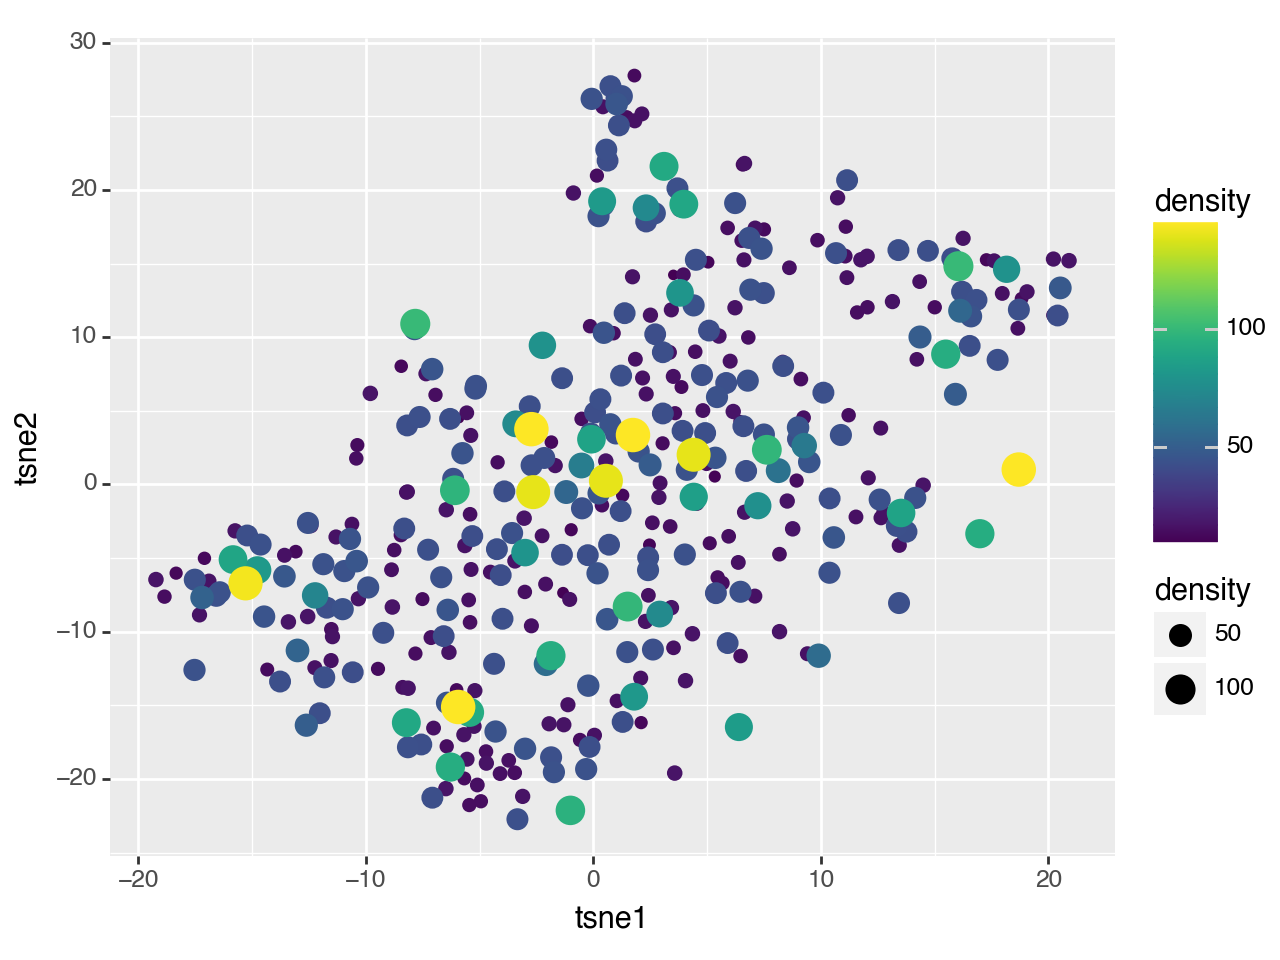

<Figure Size: (640 x 480)>

In [10]:
df["tsne1"] = embeddings_2d[:,0]
df["tsne2"] = embeddings_2d[:,1]

(
    pn.ggplot(
        df,
        pn.aes(
            x="tsne1",
            y="tsne2",
        ),
    )
    + pn.geom_point(
        pn.aes(
            color="density",
            size="density",
        ),
    )
    # + pn.geom_text()
)


Yeah I think this is not gonna work unless we actually consider for each publication its actual _previous_ neighborhood.

In [11]:
from sciterra.mapping.cartography import batch_cospsi_matrix

# Get pairwise cosine similarities for ids
all_embeddings = atl.projection.embeddings
all_cospsi_matrix = batch_cospsi_matrix(all_embeddings)

# From here on, use embedding indices instead of identifiers
# our embeddings are already in the correct order, so just use them
all_indices = np.arange(len(all_embeddings))

computing cosine similarity for 30212 embeddings with batch size 1000.


100%|██████████| 31/31 [00:20<00:00,  1.49it/s]


In [12]:
from tqdm import tqdm
from sciterra.mapping.topography import density_metric

def get_knn(ids, min_prior_pubs = 2, kernel_size = 16):

    dates = np.array([atl[identifier].publication_date for identifier in atl.ids])

    estimates = []
    neighborhoods = []

    for identifier in tqdm(ids):
        idx = atl.projection.identifier_to_index[identifier]
        # Get the date of publication
        date = atl[identifier].publication_date

        # Identify prior publications
        is_prior = dates < date
        if is_prior.sum() < min_prior_pubs:
            estimates.append(np.nan)
            continue

        # Choose valid publications
        is_other = all_indices != idx
        is_valid = is_prior & is_other
        valid_indices = all_indices[is_valid]

        kwargs = {
            "idx": idx,
            "cospsi_matrix": all_cospsi_matrix,
            "valid_indices": valid_indices,
            # "publication_indices": publication_indices,
            # "embeddings": embeddings,
            "kernel_size": kernel_size,
        }            

        estimates.append(
            density_metric(
                **kwargs,
            )
        )

        if kernel_size > len(valid_indices):
            raise Exception

        # Get 1D array of similarity scores to idx vector
        cospsi = all_cospsi_matrix[idx][valid_indices]

        knn_indices = np.argsort(cospsi)[::-1][:kernel_size]
        valid_indices_sorted = valid_indices[knn_indices]

        knns = atl.projection.indices_to_identifiers(valid_indices_sorted)

        neighborhoods.append(
            knns,
        )
        
    return {
        "estimates": estimates,
        "neighborhoods": neighborhoods,
    }

get_knn(ids = [sparse_pubs[-2].identifier])

100%|██████████| 1/1 [00:00<00:00, 1156.09it/s]


{'estimates': [22.103688176928674],
 'neighborhoods': [['9dbeda81095cfea09ca31b159daf81e268f2f9cc',
   '2a6e9a524a0386e55fa3206547324d3d0fa99548',
   'b117dd2e4b35e8a76c9d311af69f1c66ed3ecab5',
   '6ddaa8a07e2f6ffb71c3f619b1cc7b02a9bde201',
   '6103c802a763cdf38a6bebc52ee4b28d11e17601',
   '0b35863e1c67dca62ac9653961235f15c258574c',
   '17a0f23e1e2828aa509058944a61e4512191b822',
   '384764a67453266bcfad0580be88c6a43b2faee1',
   'e32e3feb2225b427caa05eb26f241671196fc942',
   '7209a373091ff817ee96f85d7b7f0676a48e36e6',
   '68b7b2a809d13bb81b4fd07afd16d17063c6f056',
   '2deb56ed7eb9566b33cab3ea69796c7c71cb4387',
   '0501b551f9324c608c0fbc519956190120e274cf',
   '94e1d6efd1f26a20229fd65f56070308eecfd025',
   'ed592ddf044dd46242a68e58248a924bfab89ae5',
   'f4c596d5eab929474caa187f2b5917c2486726b6']]}

First for sparse, then compare plot to dense

100%|██████████| 1/1 [00:00<00:00, 592.00it/s]


(17, 768)


Glyph 8727 (\N{ASTERISK OPERATOR}) missing from current font.


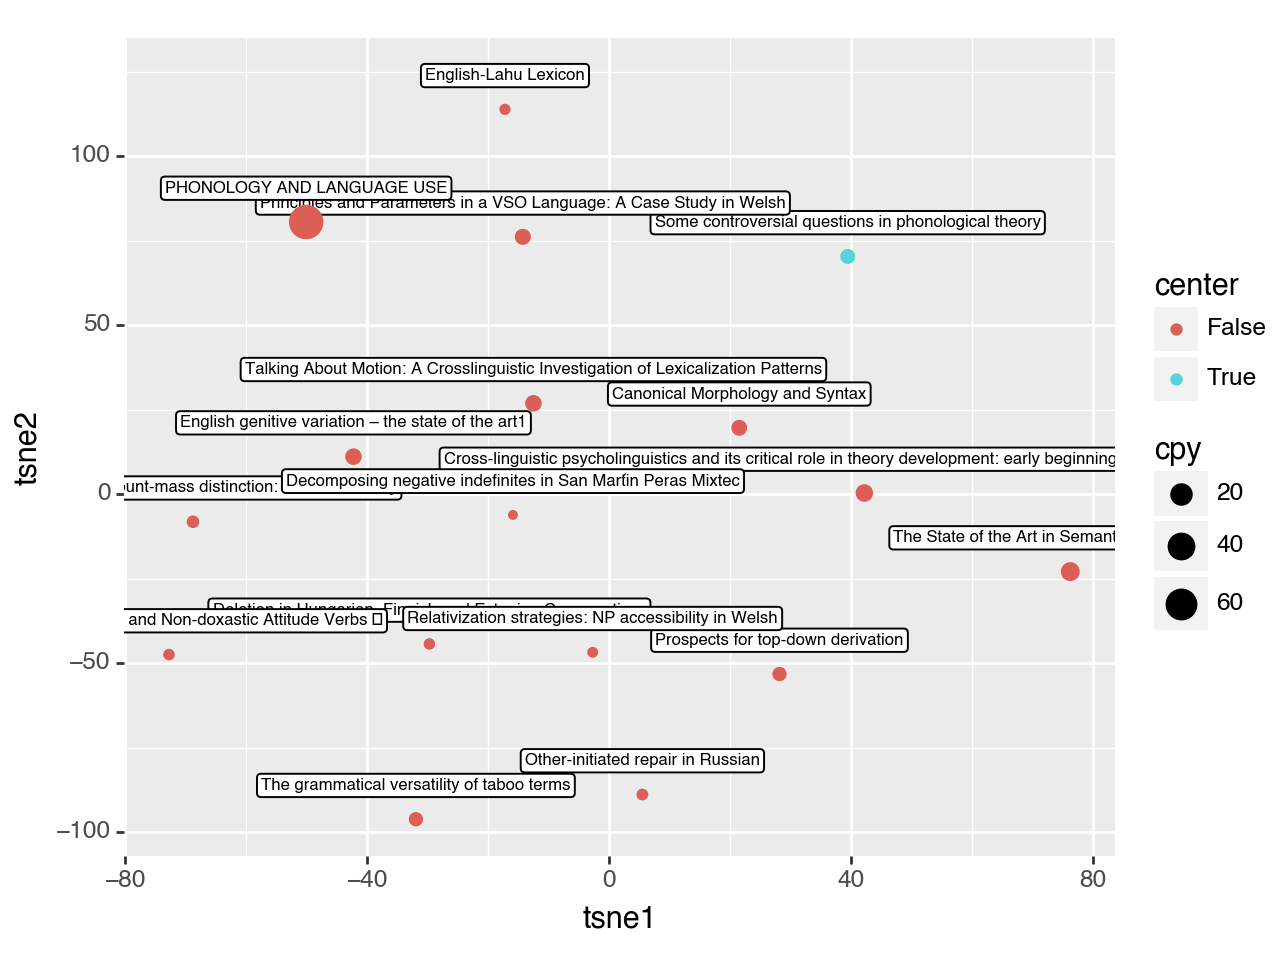

<Figure Size: (640 x 480)>

In [16]:
knn_ids = get_knn(ids = [sparse_pubs[-2].identifier])["neighborhoods"][0]

knn_embeddings = atl.projection.identifiers_to_embeddings(
    [sparse_pubs[-2].identifier] + knn_ids,
    # pub.identifier for pub in dense_pubs
)
print(knn_embeddings.shape)

knn_embeddings = knn_embeddings / np.linalg.norm(knn_embeddings, axis=1)[:, None]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
embeddings_2d = tsne.fit_transform(knn_embeddings)

pub = sparse_pubs[-2]

df_knn = pd.DataFrame(
    columns=["title", "citations", "date", "cpy", "center"],
)
df_knn["title"] = [atl[id].title for id in knn_ids]
df_knn["citations"] = [atl[id].citation_count for id in knn_ids]
df_knn["date"] = [atl[id].publication_date for id in knn_ids]
df_knn["cpy"] =  [atl[id].citation_count / get_years(atl[id].publication_date.year) for id in knn_ids]
df_knn["center"] = [False] * len(knn_ids)

df_center = pd.DataFrame(
    data=[(
        pub.title,
        pub.citation_count,
        pub.publication_date,
        pub.citation_count / get_years(pub.publication_date.year),
        True,
    )],
    columns=["title", "citations", "date", "cpy", "center"],
)

df_knn_center = pd.concat([df_center, df_knn])

df_knn_center["tsne1"] = embeddings_2d[:,0]
df_knn_center["tsne2"] = embeddings_2d[:,1]



(
    pn.ggplot(
        df_knn_center,
        pn.aes(
            x="tsne1",
            y="tsne2",
        ),
    )
    + pn.geom_label(
        pn.aes(
            label="title",
        ),
        size=6,
        nudge_y = 10,
    )
    + pn.geom_point(
        pn.aes(
            color="center",
            size="cpy",
        ),
    )    
)

100%|██████████| 1/1 [00:00<00:00, 639.38it/s]


(17, 768)


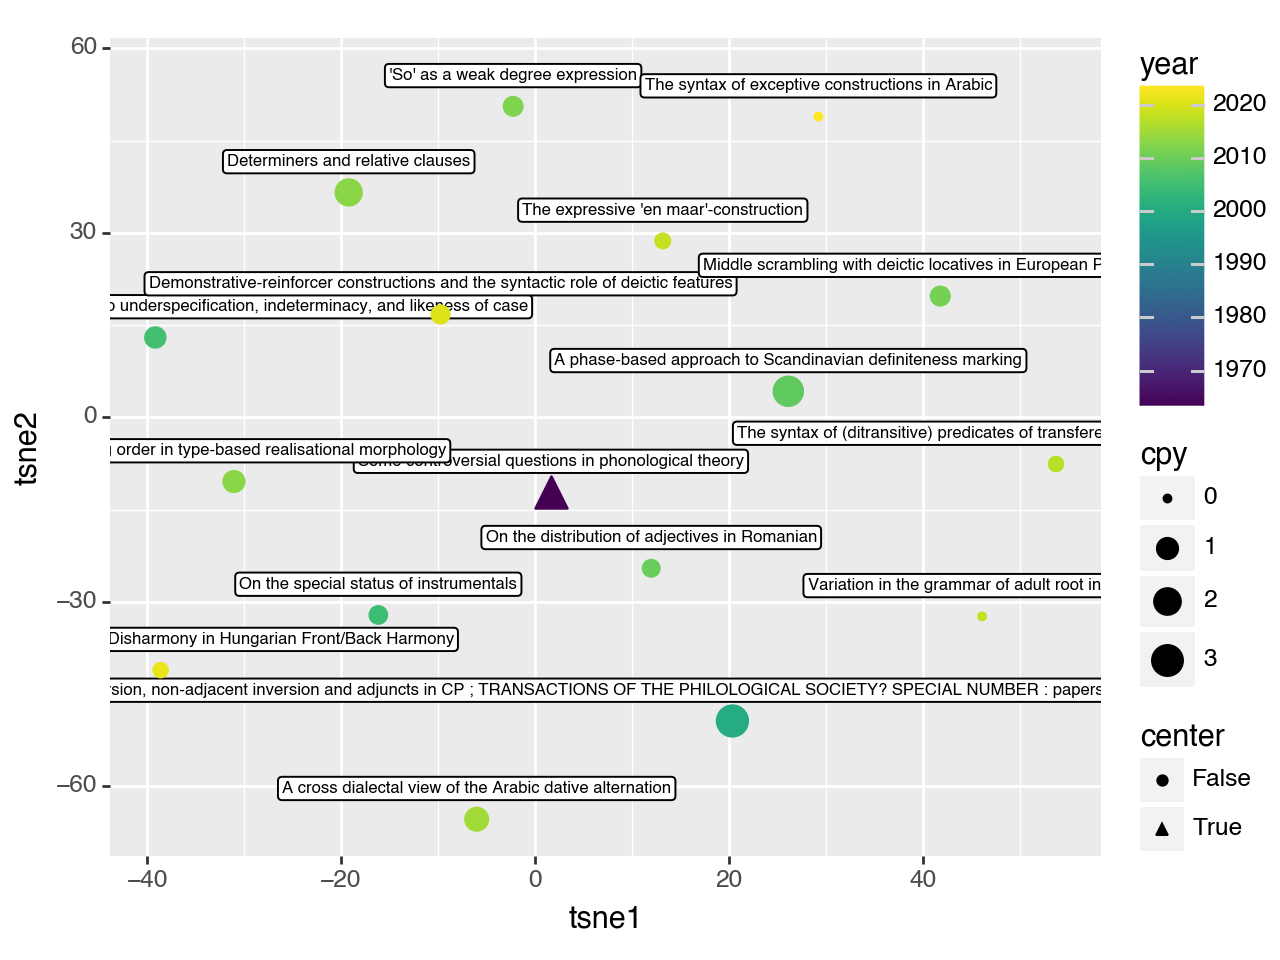

<Figure Size: (640 x 480)>

In [14]:
knn_ids = get_knn(ids = [dense_pubs[-2].identifier])["neighborhoods"][0]

knn_embeddings = atl.projection.identifiers_to_embeddings(
    [dense_pubs[-2].identifier] + knn_ids,
    # pub.identifier for pub in dense_pubs
)
print(knn_embeddings.shape)

knn_embeddings = knn_embeddings / np.linalg.norm(knn_embeddings, axis=1)[:, None]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
embeddings_2d = tsne.fit_transform(knn_embeddings)

pub = sparse_pubs[-2]

df_knn = pd.DataFrame(
    columns=["title", "citations", "date", "cpy", "center"],
)
df_knn["title"] = [atl[id].title for id in knn_ids]
df_knn["citations"] = [atl[id].citation_count for id in knn_ids]
df_knn["year"] = [atl[id].publication_date.year for id in knn_ids]
df_knn["cpy"] =  [atl[id].citation_count / get_years(atl[id].publication_date.year) for id in knn_ids]
df_knn["center"] = [False] * len(knn_ids)

df_center = pd.DataFrame(
    data=[(
        pub.title,
        pub.citation_count,
        pub.publication_date.year,
        pub.citation_count / get_years(pub.publication_date.year),
        True,
    )],
    columns=["title", "citations", "year", "cpy", "center"],
)

df_knn_center = pd.concat([df_center, df_knn])

df_knn_center["tsne1"] = embeddings_2d[:,0]
df_knn_center["tsne2"] = embeddings_2d[:,1]



(
    pn.ggplot(
        df_knn_center,
        pn.aes(
            x="tsne1",
            y="tsne2",
        ),
    )
    + pn.geom_label(
        pn.aes(
            label="title",
        ),
        size=6,
        nudge_y = 5,
    )
    + pn.geom_point(
        pn.aes(
            color="year",
            size="cpy",
            shape="center",
        ),
    )    
)

Well this isn't working very well so just move to keynote.

And let's create some mock distributions

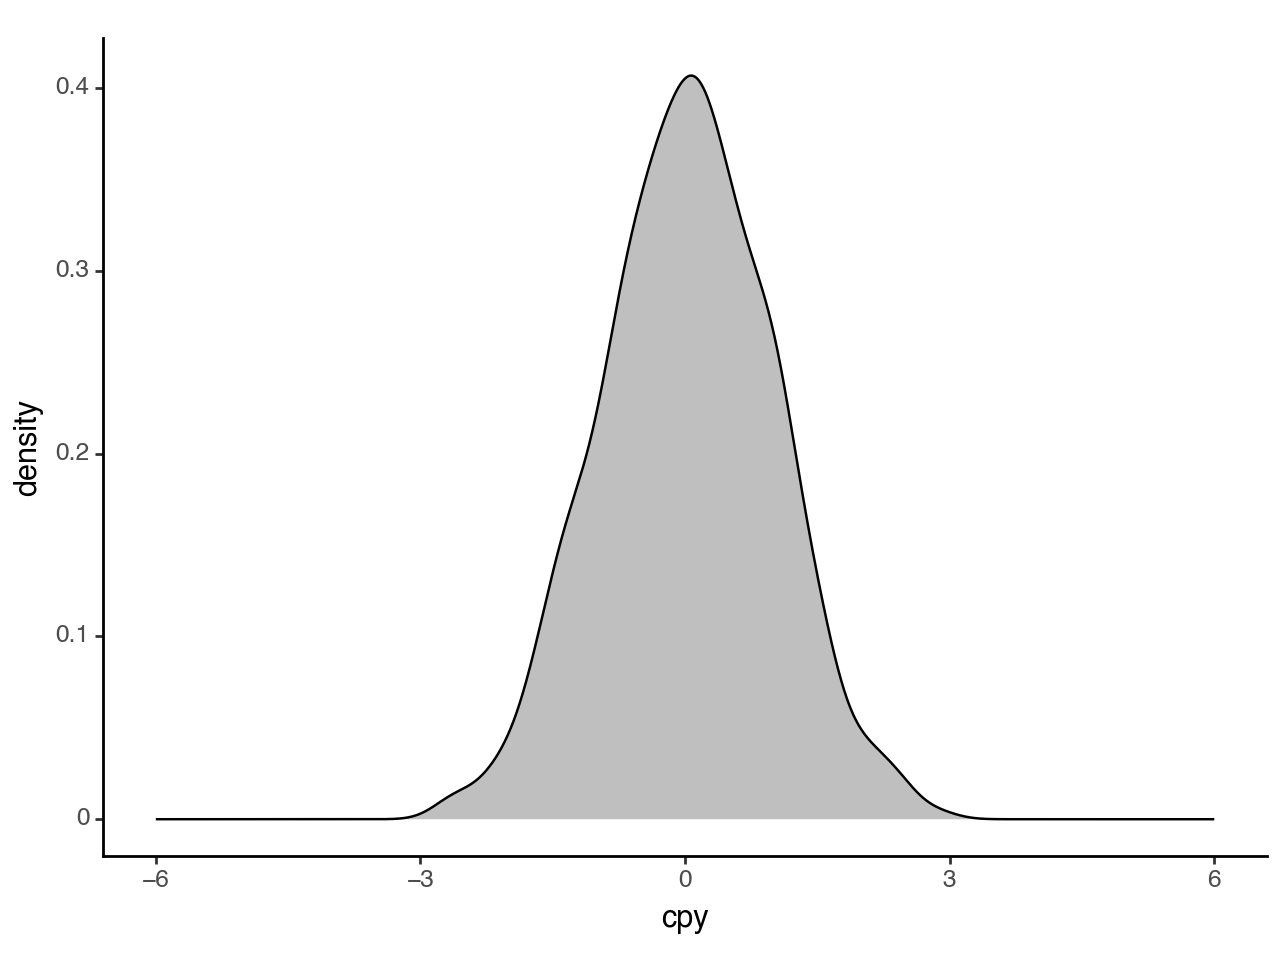

<Figure Size: (640 x 480)>

In [16]:
# dummy data

df_dummy = pd.DataFrame(
    data=np.random.normal(
        loc=0,
        scale=1,
        size=1000,
    ),
    columns=["cpy"],
)


(
    pn.ggplot(df_dummy)
    + pn.geom_density(
        pn.aes(
            x="cpy",
        ),
        fill="orange",
        alpha=0.5,
    )
    + pn.theme_classic()
    # + pn.ylim(0,.6)
    + pn.xlim(-6,6)
)